<a href="https://colab.research.google.com/github/pedrosena138/if1014-data-mining/blob/main/MAGIC_Gamma_Telescope_Data_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Universidade Federal de Pernambuco - UFPE
 
Centro de Informática - CIn
 
Disciplina: IF1014 - Tópicos Avançados em SI 5 (Soluções em Mineração de Dados)
 
Docente: Leandro Maciel Almeida
 
Discentes: Caio Fazio Ayres, Elverson Soares de Melo, Pedro Manoel Farias Sena de Lima


# Compreensão dos dados

Dono original dos dados:

    R. K. Bock
    Major Atmospheric Gamma Imaging Cherenkov Telescope project (MAGIC)
    http://wwwmagic.mppmu.mpg.de
    rkb@mail.cern.ch

Dono:

    P. Savicky
    Institute of Computer Science, AS of CR
    Czech Republic
    savicky@cs.cas.cz




Os dados foram gerados para simular o registro de partículas gama de alta energia em um telescópio gama Cherenkov atmosférico baseado no solo usando a técnica de imagem. O telescópio gama Cherenkov observa raios gama de alta energia, aproveitando a radiação emitida por partículas carregadas produzidas dentro dos chuveiros eletromagnéticos iniciados pelos gamas, e se desenvolvendo na atmosfera. Esta radiação Cherenkov (de comprimentos de onda visível a UV) vaza pela atmosfera e é registrada no detector, permitindo a reconstrução dos parâmetros do chuveiro. A informação disponível consiste em pulsos deixados pelos fótons Cherenkov recebidos nos tubos fotomultiplicadores, dispostos em um plano, a câmera. Dependendo da energia do gama primário, um total de algumas centenas a cerca de 10.000 fótons de Cherenkov são coletados, em padrões (chamados de imagem do chuveiro), permitindo discriminar estatisticamente aqueles causados ​​por gamas primários (sinal) das imagens de chuveiros hadrônicos iniciados por raios cósmicos na atmosfera superior (ao fundo).

Normalmente, a imagem de um chuveiro após algum pré-processamento é um aglomerado alongado. Seu longo eixo é orientado para o centro da câmera se o eixo do chuveiro for paralelo ao eixo óptico do telescópio, ou seja, se o eixo do telescópio for direcionado para uma fonte pontual. Uma análise de componentes principais é realizada
no plano da câmera, o que resulta em um eixo de correlação e define uma elipse. Se as deposições fossem distribuídas como uma gaussiana bivariada, esta seria uma elipse de equidensidade. Os parâmetros característicos desta elipse (muitas vezes chamados de parâmetros de Hillas) estão entre os parâmetros de imagem que podem ser usados ​​para discriminação. As deposições de energia são tipicamente assimétricas ao longo do eixo principal, e essa assimetria também pode ser usada na discriminação. Existem, além disso, outras características discriminantes, como a extensão do aglomerado no plano da imagem ou a soma total das deposições.

O conjunto de dados foi gerado por um programa Monte Carlo, Corsika, descrito em D. Heck et al., CORSIKA, Um código Monte Carlo para simular extensas chuvas de ar, Forschungszentrum Karlsruhe FZKA 6019 (1998). O programa foi executado com parâmetros que permitem observar eventos com energias abaixo de 50 GeV.

| atributo | tipo     | descrição                                                           | unidade |
|----------|----------|---------------------------------------------------------------------|---------|
| fLength  | contínuo | eixo principal da elipse                                            | mm      |
| fWidth   | contínuo | eixo menor da elipse                                                | mm      |
| fConc    | contínuo | proporção da soma dos dois pixels mais altos sobre fSize            | razão   |
| fConc1   | contínuo | proporção do pixel mais alto sobre fSize                            | razão   |
| fAsym    | contínuo | distância do pixel mais alto ao centro, projetada no eixo principal | mm      |
| fM3Long  | contínuo | raiz cúbica do terceiro momento ao longo do eixo maior              | mm      |
| fM3Trans | contínuo | raiz cúbica do terceiro momento ao longo do eixo menor              | mm      |
| fAlpha   | contínuo | ângulo do eixo maior com o vetor para a origem                      | deg     |
| fDist    | contínuo | distância da origem ao centro da elipse                             | mm      |
| class    | discreto | gamma (signal), hadron (background)                                 |         |



# Configuração

In [ ]:
#Necessário para o LVQ
# !pip install neupy numpy

Importando as bilbiotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import random

from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold,cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

from collections import Counter

# Necessário para o LVQ
# from neupy import algorithms

Ajustandos parâmetros gráficos

In [ ]:
%matplotlib inline

warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = (12, 8)

sns.set_color_codes('deep')

Ajustando parâmetros aleatórios

In [ ]:
seed_value= 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)


Caregando a base de dados

In [ ]:
# carregando os ids dos atributos
names = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans',  'fAlpha', 'fDist','class']
filepath = 'https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data'
dataframe = pd.read_csv(filepath, sep="," , names=names )

# Análise Exploratória

## Visão Geral

Analisando os primeiros 5 registros da base

In [ ]:
dataframe.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


Verificando: 
- Total de registros 
- Tipos dos dados
- Valores ausentes

In [ ]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fLength   19020 non-null  float64
 1   fWidth    19020 non-null  float64
 2   fSize     19020 non-null  float64
 3   fConc     19020 non-null  float64
 4   fConc1    19020 non-null  float64
 5   fAsym     19020 non-null  float64
 6   fM3Long   19020 non-null  float64
 7   fM3Trans  19020 non-null  float64
 8   fAlpha    19020 non-null  float64
 9   fDist     19020 non-null  float64
 10  class     19020 non-null  object 
dtypes: float64(10), object(1)
memory usage: 1.6+ MB


A base possui 19020 registros, sem nenhum dado faltante e todas as colunas tirando a `class` são valores numéricos

Verificação de valores duplicados

In [ ]:
print('Qtd. de valores duplicados:', sum(dataframe.duplicated()))

Qtd. de valores duplicados: 115


## Dados Categóricos

Como visto anteriormente, a base só possui uma coluna categórica, a coluna `class`

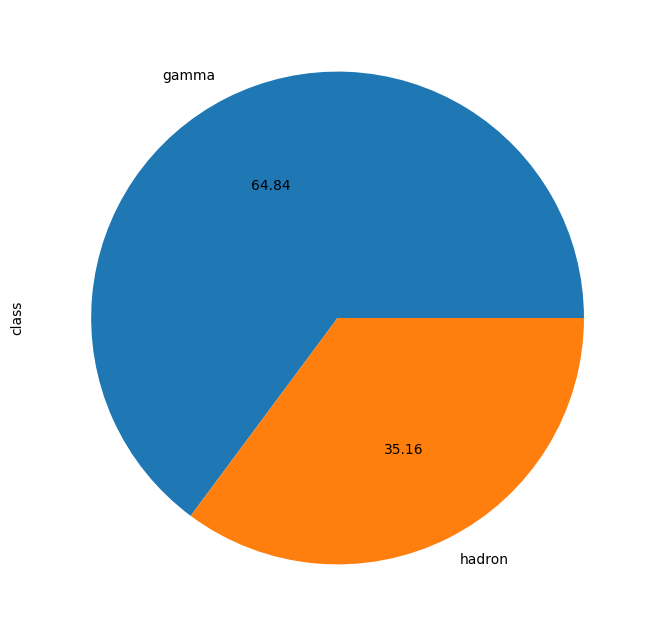

In [ ]:
  dataframe['class'].value_counts().plot.pie(labels=['gamma', 'hadron'], autopct='%.2f')
  plt.show()

É possível ver que a base apresenta um desbalanceamento na coluna `class`. Por razões técnicas, o número de *h* eventos é subestimado. Nos dados reais, a classe *h* representa a maioria dos eventos.

## Dados Numéricos

Visão geral da distribuição dos dados numéricos

In [ ]:
dataframe.describe().T

,count,mean,std,min,25%,50%,75%,max
fLength,19020.0,53.250154,42.364855,4.2835,24.336000,37.14770,70.122175,334.1770
fWidth,19020.0,22.180966,18.346056,0.0000,11.863800,17.13990,24.739475,256.3820
fSize,19020.0,2.825017,0.472599,1.9413,2.477100,2.73960,3.101600,5.3233
fConc,19020.0,0.380327,0.182813,0.0131,0.235800,0.35415,0.503700,0.8930
fConc1,19020.0,0.214657,0.110511,0.0003,0.128475,0.19650,0.285225,0.6752
fAsym,19020.0,-4.331745,59.206062,-457.9161,-20.586550,4.01305,24.063700,575.2407
fM3Long,19020.0,10.545545,51.000118,-331.7800,-12.842775,15.31410,35.837800,238.3210
fM3Trans,19020.0,0.249726,20.827439,-205.8947,-10.849375,0.66620,10.946425,179.8510
fAlpha,19020.0,27.645707,26.103621,0.0000,5.547925,17.67950,45.883550,90.0000
fDist,19020.0,193.818026,74.731787,1.2826,142.492250,191.85145,240.563825,495.5610


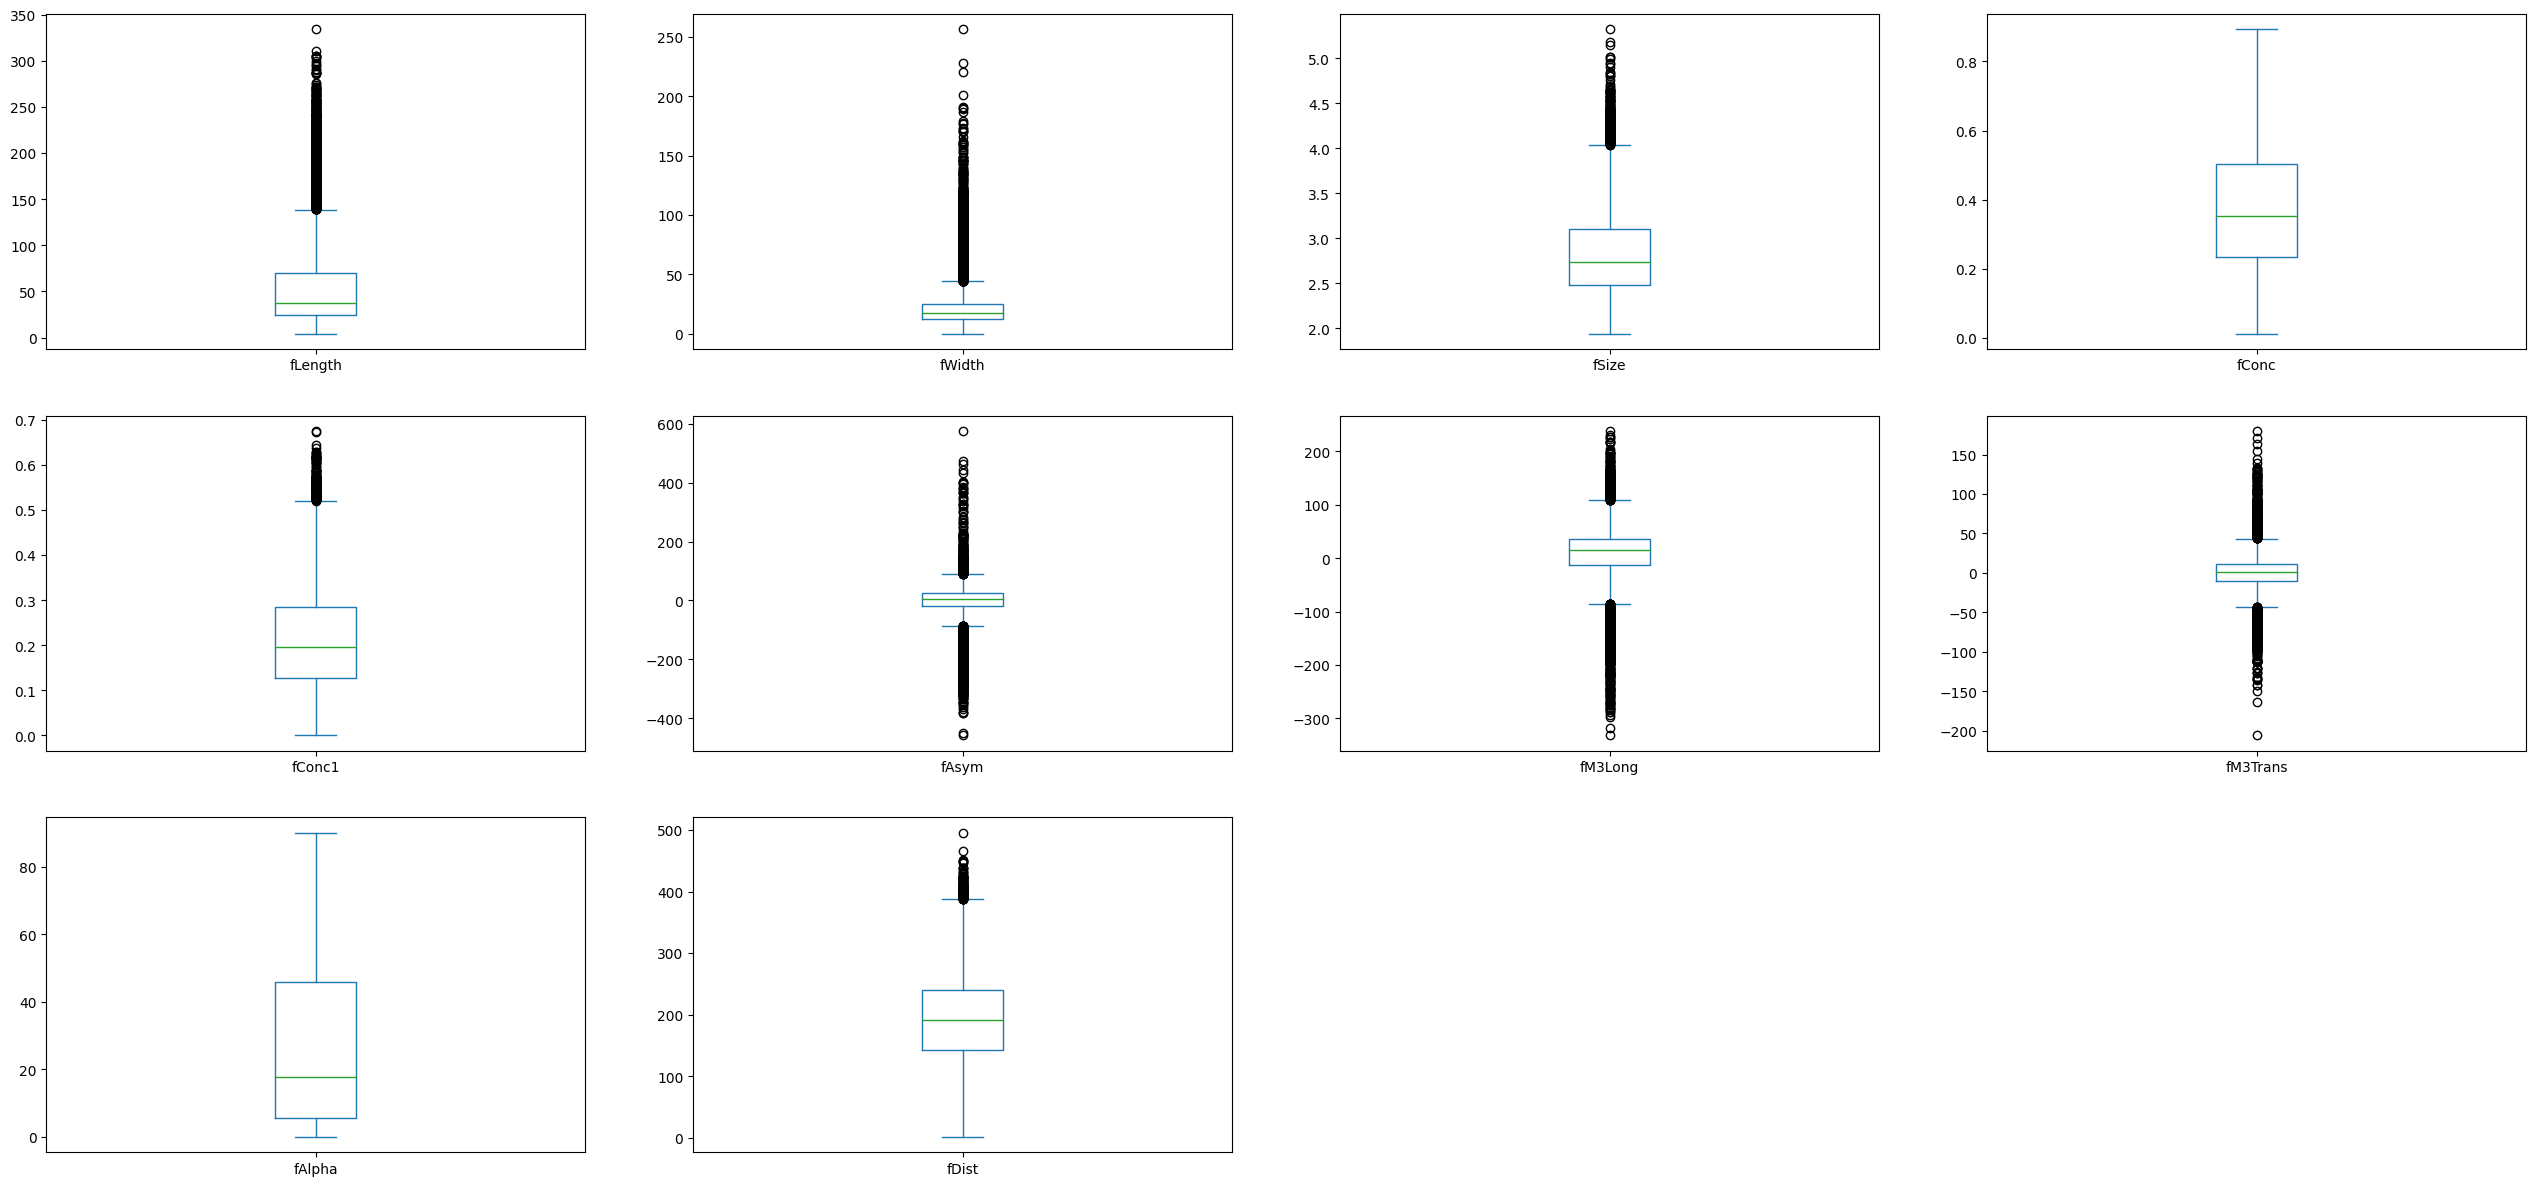

In [ ]:
dataframe.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(32,20))
plt.show()

Analisando os boxplots, é possível ver uma grande quantidade de outliers na maioria dos dados categóricos. A criação de histogramas auxilia a visualizar melhor a tendência mostrada nos boxplots.

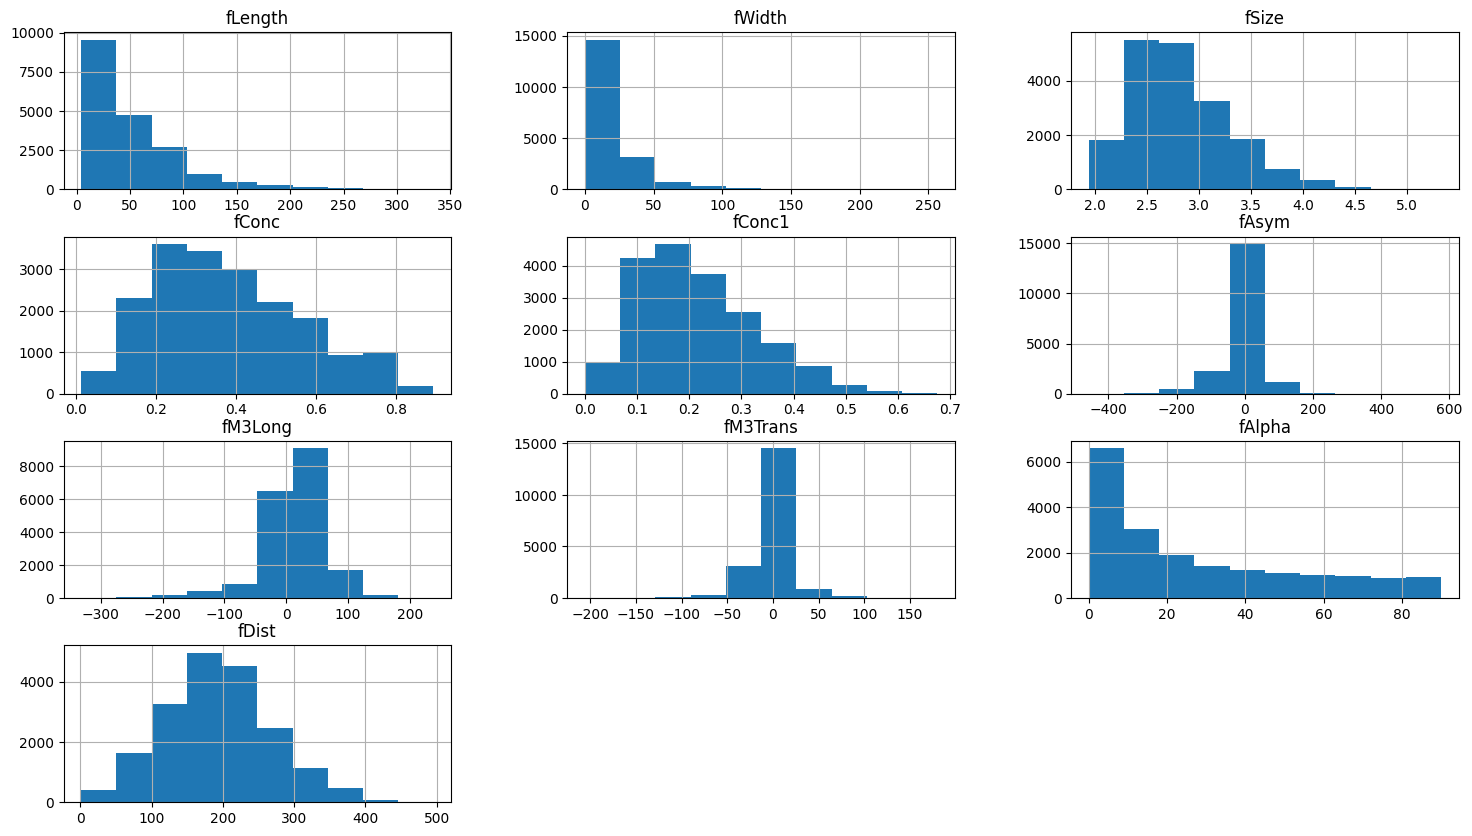

In [ ]:
dataframe.hist(figsize=(18,10))
plt.show()

Para verificar a correlação dos dados é necessário utilizar a matriz de correlação

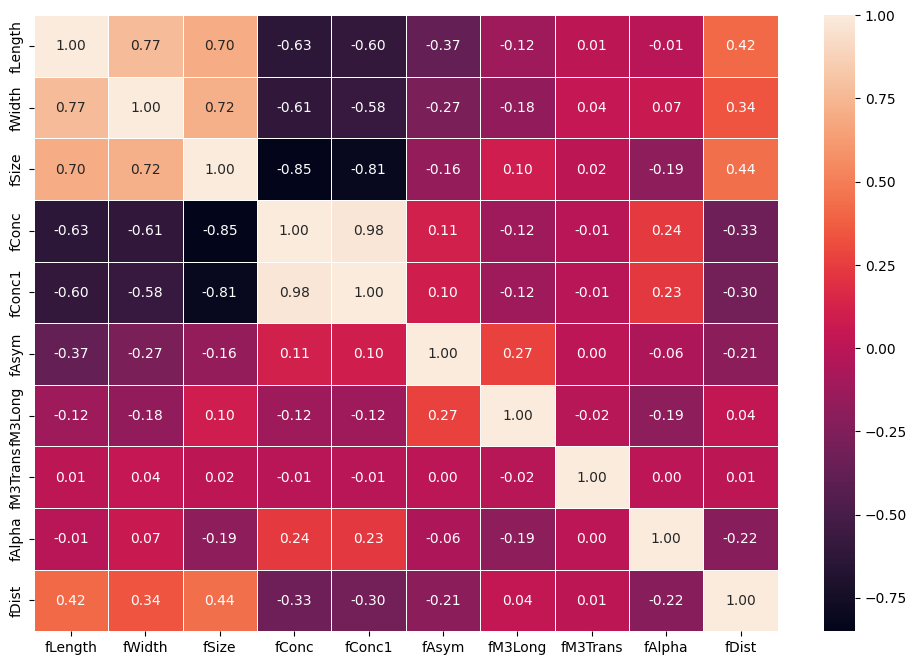

In [ ]:
corr_matrix = dataframe.corr()
sns.heatmap(corr_matrix, annot = True, fmt=".2f", linewidths=.6)
plt.show()

Observa-se que há uma correlação direta quase perfeita entre os atributos fConc e fConc1 (R = 0.98), uma correlação alta entre fLength e fWidth (R=0.77), fLength e fSize (R = 0. 70) e, fWidth e fSize (R = 0.72). A base de dados apresenta também uma forte correlação inversa entre fConc e fSize (R= -0,85) e fConc1 e fSize (R= -0,81). Para auxiliar nessa análise pode-se utilizar gráficos de dispersão

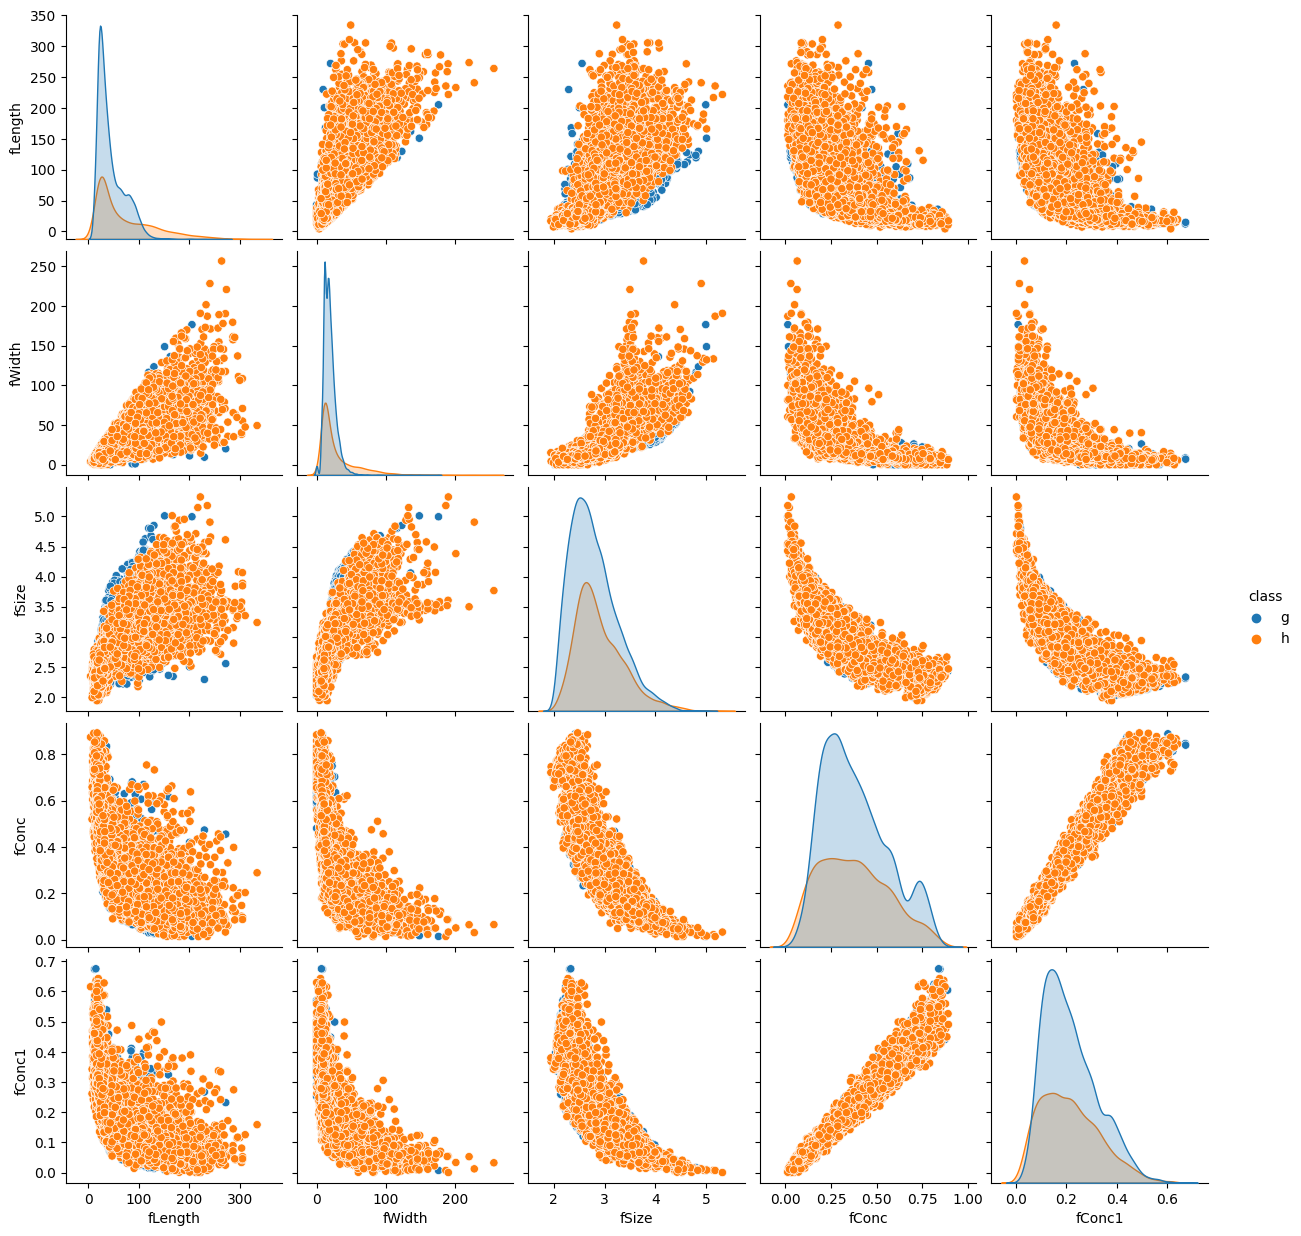

In [ ]:
subset = dataframe[['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'class']]
sns.pairplot(subset, hue='class')

plt.show()

# Pré-processamento

Os processametos detectados necessários foram:
- Alterar o tipo de dado do rótulo de classe;
- Remover as 115 instâncias duplicadas presentes na base;
- Remover atributos com uma correlação alta (R > 0.70)
- Realizar o balanceamento de classes;
- Verificar o impacto dos outliers nos algoritmos de classificação
- Realizar a normalização dos dados dos atributos para que fiquem em escala similar.


## Remoção

Eliminando instâncias duplicadas

In [ ]:
processed_dataframe = dataframe.copy()
processed_dataframe.drop_duplicates(inplace=True)
print('Qtd. de registros duplicados:', sum(processed_dataframe.duplicated()))

Qtd. de registros duplicados: 0


Removendo atributos com uma correlação *| r |* > 0.90. Desse modo a matriz de correlação fica desse jeito

Atributos com |r| > 0.90: ['fConc1']



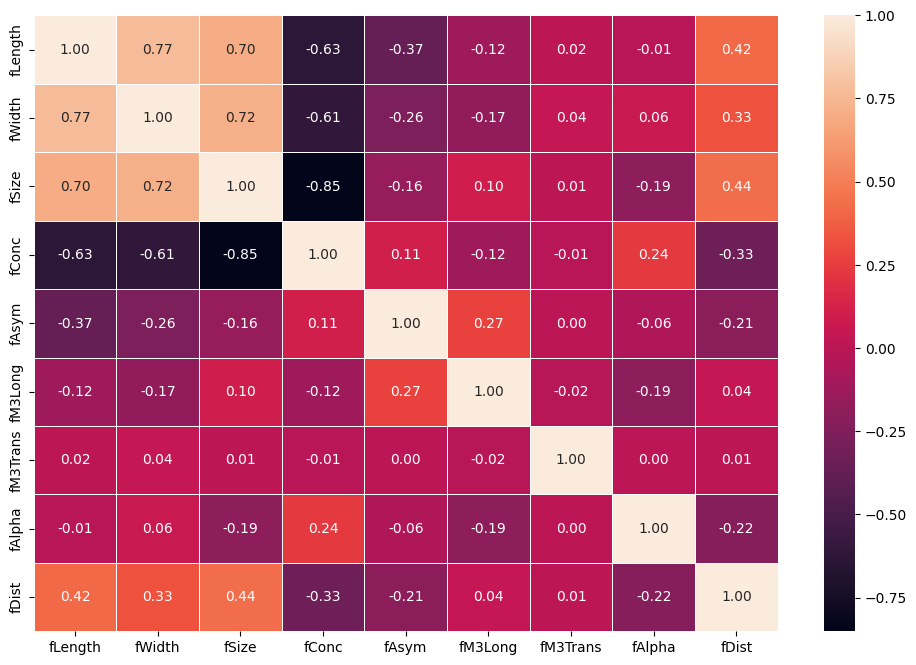

In [ ]:
# triângulo superior da matrix de correlação
corr_matrix = processed_dataframe.corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# atributos com correlação maior que 0.9
columns_to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.90)]
print('Atributos com |r| > 0.90:', columns_to_drop, end='\n\n')

processed_dataframe.drop(columns_to_drop, axis=1, inplace=True)

corr_matrix = processed_dataframe.corr()
sns.heatmap(corr_matrix, annot = True, fmt=".2f", linewidths=.6)
plt.show()

## Codificação

Transformando coluna `class` em um atributo numérico para facilitar a classificação. Para isso vamos usar o LabelEncoder

In [ ]:
encoder = LabelEncoder()
y = processed_dataframe['class'].values.reshape(-1, 1)

encoder.fit(y)

# Esse passo é necessário para atribuir h = 0 e g = 1, já que g é a classe positiva
encoder.classes_ = np.flip(encoder.classes_)

processed_dataframe['class'] = encoder.transform(y)
processed_dataframe.head()

,fLength,fWidth,fSize,fConc,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,27.7004,22.0110,-8.2027,40.0920,81.8828,1
1,31.6036,11.7235,2.5185,0.5303,26.2722,23.8238,-9.9574,6.3609,205.2610,1
2,162.0520,136.0310,4.0612,0.0374,116.7410,-64.8580,-45.2160,76.9600,256.7880,1
3,23.8172,9.5728,2.3385,0.6147,27.2107,-6.4633,-7.1513,10.4490,116.7370,1
4,75.1362,30.9205,3.1611,0.3168,-5.5277,28.5525,21.8393,4.6480,356.4620,1


## Embaralhamento das instâncias para garantir a consistência

In [ ]:
shuffled_dataframe = processed_dataframe.sample(frac=1, random_state=seed_value).reset_index()
shuffled_dataframe.drop("index", inplace=True, axis=1)
shuffled_dataframe.head()

,fLength,fWidth,fSize,fConc,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,20.8003,9.5045,2.2405,0.6264,-4.7991,15.6805,-10.5121,63.5975,131.829,1
1,14.6148,9.2816,2.4972,0.6027,-1.2913,-18.5501,8.8930,36.5934,66.066,0
2,89.3234,31.0659,3.2227,0.1473,-112.5040,-59.0359,-24.6718,9.3521,220.389,1
3,25.8499,8.5086,2.5308,0.5626,12.2595,10.3932,-4.4572,68.8430,165.671,0
4,41.9782,22.1387,2.8748,0.3042,31.1820,25.3913,19.0259,20.5966,139.299,1


## Divisão em conjuntos de treino e teste

In [ ]:
X = shuffled_dataframe.drop('class', axis=1).values
y = shuffled_dataframe['class'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_value)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=seed_value, shuffle=True)

## Padronização

Como visto pelo histograma os dados apresentam muitos outliers. Decidimos então utilizar o `RobustScaler` para padronizar os dados.

In [ ]:
scaler = RobustScaler()

print('Dados de treinamento antes da padronização\n\n', X_train, end='\n\n----------------------------------\n\n')
# Ajustanto o modelo ao conjunto de treino e fazendo a transformação
X_train = scaler.fit_transform(X_train)

# transformando o conjunto de teste com o dados modelados no conjunto de treino
X_test = scaler.transform(X_test)
# X_val = scaler.transform(X_val)

print('Dados de treinamento depois da padronização\n\n', X_train)

Dados de treinamento antes da padronização

 [[ 13.1233  10.9602   2.3086 ... -11.6362  22.962  171.086 ]
 [ 27.6126   9.1748   2.3683 ...  -7.1786  20.189  257.979 ]
 [ 53.238   20.45     3.0406 ...  12.9959   5.6926 235.78  ]
 ...
 [ 59.4233  27.311    3.1318 ...  23.091   10.973  215.284 ]
 [ 17.1862   7.246    2.3064 ...  -5.4289  12.358   81.6967]
 [ 21.1253  12.5417   2.3294 ...  -9.9628  30.572  133.871 ]]

----------------------------------

Dados de treinamento depois da padronização

 [[-0.5221884  -0.48099778 -0.68524054 ... -0.58895348  0.13165217
  -0.21006735]
 [-0.20642124 -0.62041245 -0.59005939 ... -0.38342733  0.06309544
   0.68050444]
 [ 0.35203638  0.26002233  0.48180478 ...  0.54675644 -0.29529831
   0.4529855 ]
 ...
 [ 0.48683341  0.79577008  0.62720714 ...  1.01221026 -0.16475126
   0.24292072]
 [-0.4336451  -0.77102464 -0.68874806 ... -0.30275408 -0.13050997
  -1.12622387]
 [-0.34779979 -0.35750484 -0.6520786  ... -0.51179818  0.31979381
  -0.59148621]]


## Realizando equilíbrio das classes

Primeiro vamos realizar testes com alguns métodos de undersample e oversample. O método que será realmente aplicado nos dados será aquele que irá gerar o melhor resultado no teste

In [ ]:
# estabelescendo alguns tipos de undersample/oversample
smote = SMOTE(random_state=42)
rus = RandomUnderSampler(random_state=42)
nearmiss = NearMiss(version=1)

#criando os novos conjuntos balandeados
X_train_smote, y_train_smote= smote.fit_resample(X_train, y_train)
X_train_rus, y_train_rus= rus.fit_resample(X_train, y_train)
X_train_nearmiss, y_train_nearmiss= nearmiss.fit_resample(X_train, y_train)

Vamos agora avaliar os resultados

In [ ]:
rf = RandomForestClassifier()
rus_model = rf.fit(X_train_rus, y_train_rus)
rus_y_pred = rus_model.predict(X_test)
print("Resultado do RandomUnderSampler")
print(classification_report(y_test, rus_y_pred))

rf = RandomForestClassifier()
nearmiss_model = rf.fit(X_train_nearmiss, y_train_nearmiss)
nearmiss_y_pred = nearmiss_model.predict(X_test)
print("Resultado do UnderSample nearmiss")
print(classification_report(y_test, nearmiss_y_pred))

rf = RandomForestClassifier()
smote_model = rf.fit(X_train_smote, y_train_smote)
smote_y_pred = smote_model.predict(X_test)
print("Resultado do Over Sample SMOTE")
print(classification_report(y_test, smote_y_pred))

Resultado do RandomUnderSampler
              precision    recall  f1-score   support

           0       0.78      0.83      0.81      1263
           1       0.91      0.88      0.90      2518

    accuracy                           0.87      3781
   macro avg       0.85      0.86      0.85      3781
weighted avg       0.87      0.87      0.87      3781

Resultado do UnderSample nearmiss
              precision    recall  f1-score   support

           0       0.56      0.84      0.67      1263
           1       0.89      0.66      0.76      2518

    accuracy                           0.72      3781
   macro avg       0.72      0.75      0.72      3781
weighted avg       0.78      0.72      0.73      3781

Resultado do Over Sample SMOTE
              precision    recall  f1-score   support

           0       0.81      0.80      0.81      1263
           1       0.90      0.91      0.90      2518

    accuracy                           0.87      3781
   macro avg       0.85      0.

O melhor resultado foi obtido com a aplicação do SMOTE então vamos aplica-lo aos dois conjuntos

In [ ]:
#Realizando o balanceamento no conjunto de treino
X_train, y_train= smote.fit_resample(X_train, y_train)
#Realizando o balanceamento no conjunto de teste
X_test, y_test= smote.fit_resample(X_test, y_test)

In [ ]:
print("O novo valor de classes balanceadas no cojunto de treino é")
print(sorted(Counter(y_train).items()))
print("O novo valor de classes balanceadas no cojunto de teste é")
print(sorted(Counter(y_test).items()))

O novo valor de classes balanceadas no cojunto de treino é
[(0, 9814), (1, 9814)]
O novo valor de classes balanceadas no cojunto de teste é
[(0, 2518), (1, 2518)]


O número total de instâncias na base subiu, dessa forma, de 18905 para 24664

# Variação paramétrica

Nesta etapa serão realizados experimentos com K-NN, LVQ, Árvore de decisão, SVM, Random Forest, Rede Neural MLP, Comitê de Redes Neurais Artificiais (BaggingClassifier) e um comitê heterogêneo, para determinar quais os melhores parâmetros que podem ser aplicados aos algoritmos para execução da tarefa de predição de classes.

In [ ]:
cv = StratifiedKFold(n_splits=10)

def search_best_estimator(estimator, params, X_train, y_train, cv):
    search = GridSearchCV(estimator, params, n_jobs=-1, cv=cv, verbose=3, scoring ="roc_auc", refit="roc_auc")

    result = search.fit(X_train, y_train)

    return result

def create_fig(search):
    #salva os resultados do GridSearchCV
    results_df = pd.DataFrame(search.cv_results_)
    
    results_df = results_df.sort_values(by=["rank_test_score"])
    
    results_df = results_df.set_index(
        results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
    ).rename_axis("Parameters")
    
    best_results_df = results_df.head(10)    
    # create df of model scores ordered by performance
    
    model_scores = best_results_df.filter(regex=r"split\d*_test_score")  #seleciona apenas as colunas dos resultados dos testes
    
    # plot 10 examples of dependency between cv fold and AUC scores
    fig, ax = plt.subplots()
    sns.lineplot(
        data=model_scores.transpose().iloc[:10],
        dashes=False,
        palette="Set1",
        marker="o",
        alpha=0.5,
        ax=ax,
    )
    ax.set_xlabel("CV test fold", size=12, labelpad=10)
    ax.set_ylabel("Model AUC", size=12)
    ax.tick_params(bottom=True, labelbottom=False)
    plt.show()

In [ ]:
# lvqnet = algorithms.LVQ()

## KNN

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
=========Grid Search Results for KNN==========
Best Score: 0.9575719188528892
Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'distance'}


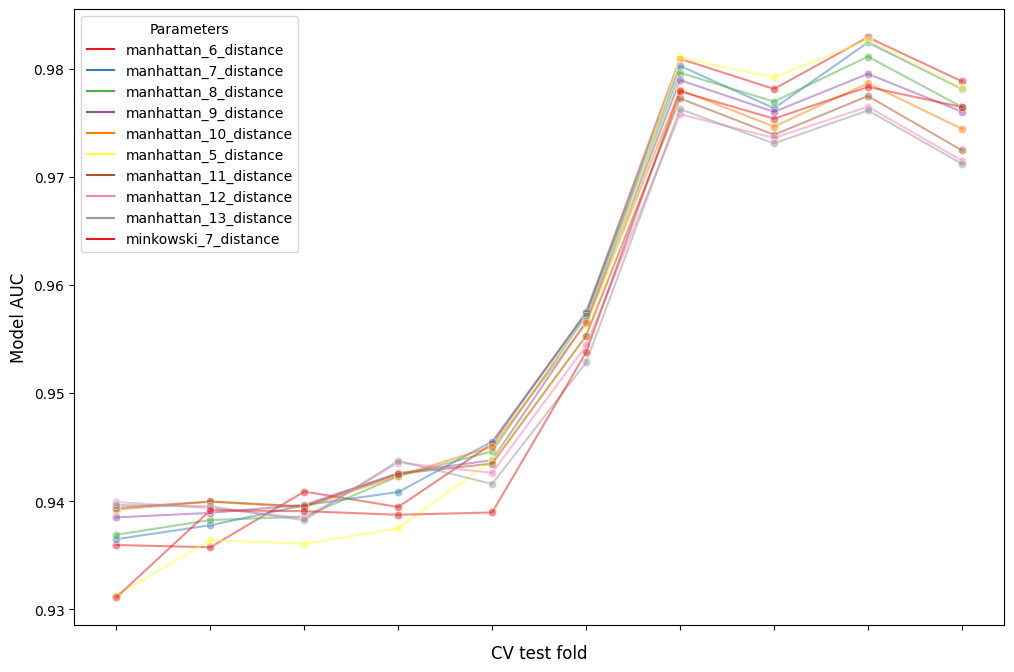

In [ ]:
knn = KNeighborsClassifier(n_jobs=-1)

param_grid = {
    'n_neighbors': list(range(1, 31)), 
    'metric': ["euclidean", "manhattan", 'minkowski'],
    'weights': ['uniform', 'distance']
}

result_knn = search_best_estimator(knn, param_grid, X_train, y_train, cv)

print('=========Grid Search Results for KNN==========')
print('Best Score: %s' % result_knn.best_score_)
print('Best Hyperparameters: %s' % result_knn.best_params_)

best_knn = result_knn.best_estimator_

create_fig(result_knn)

## Árvore de decisão

Fitting 10 folds for each of 160 candidates, totalling 1600 fits
=========Grid Search Results for Decision Tree==========
Best Score: 0.9034364434815376
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 2}


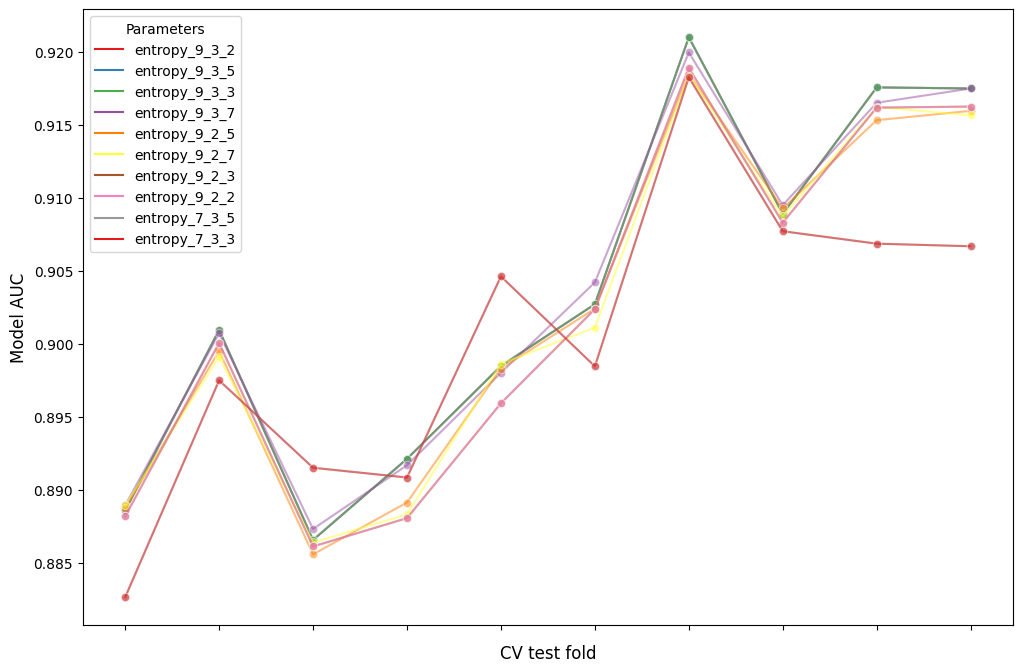

In [ ]:
decision_tree = DecisionTreeClassifier(random_state=seed_value)

param_space = {
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2,3,5,7],
    'max_depth': [3,5,6,7,9,11,13,15,17,19],
    'min_samples_leaf': [2, 3]
}

result_tree =  search_best_estimator(decision_tree, param_space, X_train, y_train, cv)

print('=========Grid Search Results for Decision Tree==========')
print('Best Score: %s' % result_tree.best_score_)
print('Best Hyperparameters: %s' % result_tree.best_params_)

best_tree = result_tree.best_estimator_
create_fig(result_tree)

## Random Forrest

Fitting 10 folds for each of 160 candidates, totalling 1600 fits
=========Grid Search Results for Random Forrest==========
Best Score: 0.9589520389720587
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 19, 'min_samples_leaf': 2, 'min_samples_split': 3}


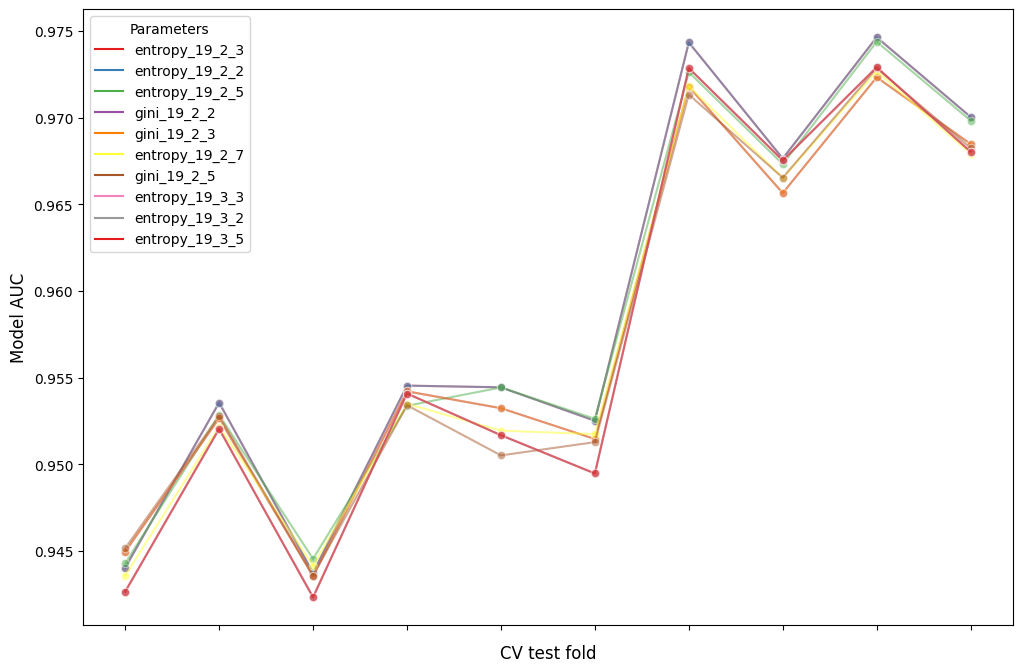

In [ ]:
rfc = RandomForestClassifier(n_jobs=-1, random_state=seed_value)

param_space = {
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2,3,5,7],
    'max_depth': [3,5,6,7,9,11,13,15,17,19],
    'min_samples_leaf': [2, 3]
}

result_rfc = search_best_estimator(rfc, param_space, X_train, y_train, cv)

print('=========Grid Search Results for Random Forrest==========')
print('Best Score: %s' % result_rfc.best_score_)
print('Best Hyperparameters: %s' % result_rfc.best_params_)

best_rfc = result_rfc.best_estimator_

create_fig(result_rfc)

## SVM

In [ ]:
svc = SVC(random_state=seed_value)

param_grid = {
    'C': [0.1, 1, 10, 50, 100, 200], 
    'gamma': [1, 0.1, 0.05, 0.01, 0.001, 0.005],
    'kernel': ['rbf', 'sigmoid']
}

result_svc = search_best_estimator(svc, param_grid, X_train, y_train, cv)

print('=========Grid Search Results for SVM==========')
print('Best Score: %s' % result_svc.best_score_)
print('Best Hyperparameters: %s' % result_svc.best_params_)

best_svc = result_svc.best_estimator_
create_fig(result_svc)

"svc = SVC(random_state=seed_value)\n\nparam_grid = {\n    'C': [0.1, 1, 10, 50, 100, 200], \n    'gamma': [1, 0.1, 0.05, 0.01, 0.001, 0.005],\n    'kernel': ['rbf', 'sigmoid']\n}\n\nresult_svc = search_best_estimator(svc, param_grid, X_train, y_train, cv)\n\nprint('=========Grid Search Results for SVM==========')\nprint('Best Score: %s' % result_svc.best_score_)\nprint('Best Hyperparameters: %s' % result_svc.best_params_)\n\nbest_svc = result_svc.best_estimator_\ncreate_fig(result_svc)"

Fitting 10 folds for each of 72 candidates, totalling 720 fits

=========Grid Search Results for SVM==========

Best Score: 0.9437886133870977

Best Hyperparameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}

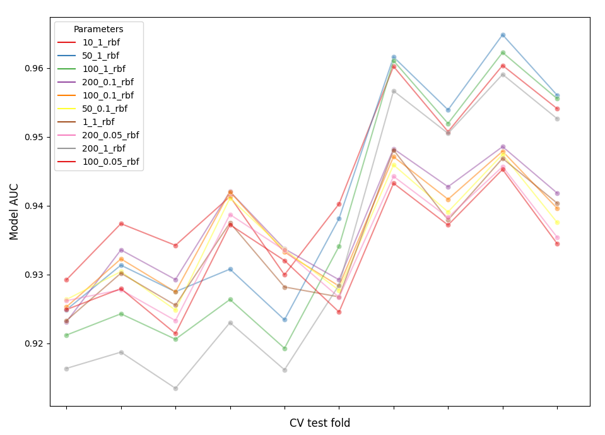

## MLP

In [ ]:
params_grid = {
    'activation': ["relu", "tanh"], 
    'solver': ["adam","sgd"],
    'alpha': [0.00001, 0.0001, 0.001],
    'learning_rate': ["invscaling", "adaptive"],
    'hidden_layer_sizes':[(10,10), (10,20), (10, 5)]
}

mlp = MLPClassifier(solver= "adam", random_state=seed_value)

result_mlp = search_best_estimator(mlp, param_grid, X_train, y_train, cv)

print('=========Grid Search Results for MLP==========')
print('Best Score: %s' % result_mlp.best_score_)
print('Best Hyperparameters: %s' % result_mlp.best_params_)

best_mlp = result_mlp.best_estimator_
create_fig(result_mlp)

Fitting 10 folds for each of 72 candidates, totalling 720 fits

=========Grid Search Results for MLP==========

Best Score: 0.9357824086832813

Best Hyperparameters: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (10, 10), 'learning_rate': 'invscaling', 'solver': 'adam'}
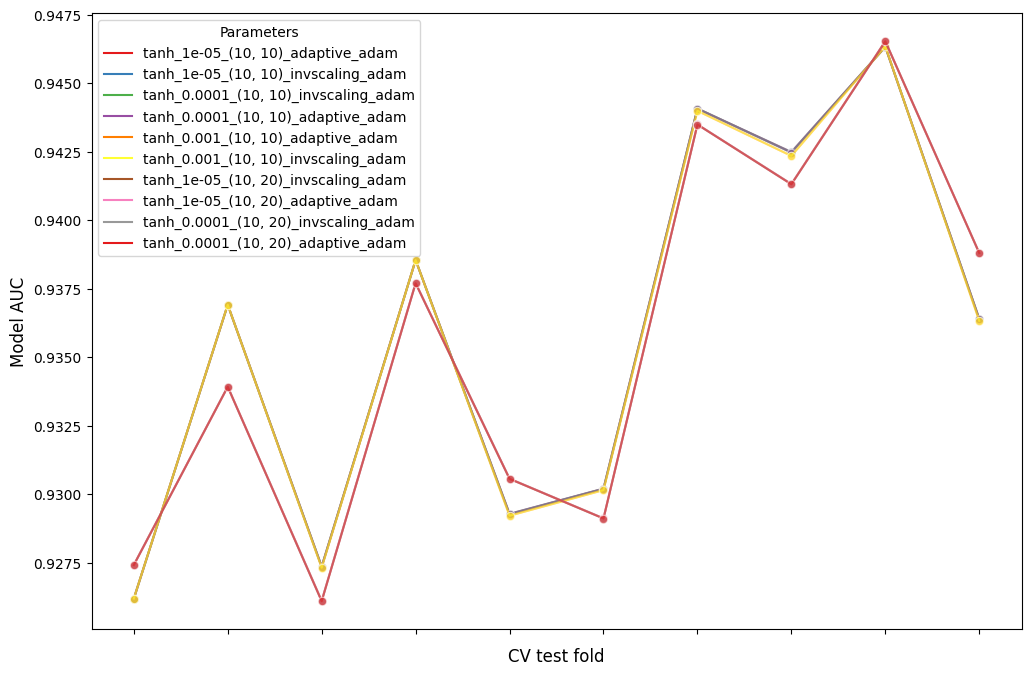

## BMLP

In [ ]:
params_grid = {
    'n_estimators': [10,25,35,50,65],
    'max_features' : [3, 5, 7, 9],
    'max_samples': [30, 50, 100, 150]
}

bmlp = BaggingClassifier(base_estimator = best_mlp, n_jobs= -1, random_state=seed_value)
result_bmlp = search_best_estimator(bmlp, param_grid, X_train, y_train, cv)

print('=========Grid Search Results for BMLP==========')
print('Best Score: %s' % result_bmlp.best_score_)
print('Best Hyperparameters: %s' % result_bmlp.best_params_)

best_bmlp = result_bmlp.best_estimator_
print(best_bmlp)
create_fig(result_bmlp)

Fitting 10 folds for each of 80 candidates, totalling 800 fits

=========Grid Search Results for BMLP==========

Best Score: 0.8530941537236967

Best Hyperparameters: {'max_features': 7, 'max_samples': 150, 'n_estimators': 50}

BaggingClassifier(base_estimator=MLPClassifier(activation='tanh', alpha=1e-05,
                                               hidden_layer_sizes=(10, 10),
                                               learning_rate='invscaling',
                                               random_state=42),
                  max_features=7, max_samples=150, n_estimators=50, n_jobs=-1,
                  random_state=42)

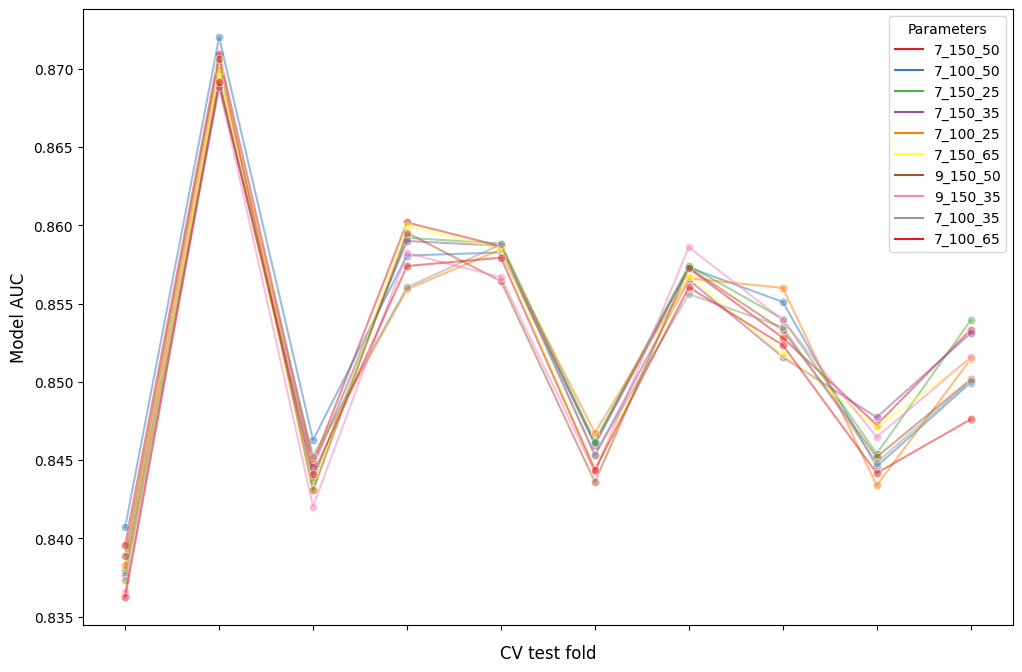

## StackingClassifier

In [ ]:
#criando manualmente os classificadores com base nas saídas anteriores (para não executar tudo novamente)
best_mlp = MLPClassifier(activation= 'tanh', alpha= 1e-05, hidden_layer_sizes= (10, 10), learning_rate='invscaling', solver= 'adam', random_state=seed_value)
best_knn = KNeighborsClassifier(metric= 'manhattan', n_neighbors= 6, weights= 'distance')
best_rfc = RandomForestClassifier(criterion= 'entropy', max_depth= 19, min_samples_leaf= 2, min_samples_split= 3, random_state=seed_value)
best_tree = DecisionTreeClassifier(criterion= 'entropy', max_depth= 9, min_samples_leaf= 3, min_samples_split= 2, random_state=seed_value)
best_bmlp = BaggingClassifier(base_estimator=best_mlp, max_features=7, max_samples=150, n_estimators=50, random_state=seed_value)
best_svc = SVC(C= 10, gamma= 1, kernel= 'rbf', random_state=seed_value)

In [ ]:
#Não há hiperparâmetro para otimizar
stc = StackingClassifier(estimators = [("mlp", best_mlp), ("knn",best_knn), ("svm", best_svc), ("rf",best_rfc), ("CART",best_tree),("bmlp",best_bmlp)], n_jobs=-1)

resul_stc = cross_val_score(stc, X_train, y_train, cv=cv, n_jobs=-1, scoring ="roc_auc")

print('=========Results for StackingClassifier==========')
print('Mean Score: %s' % resul_stc.mean())

=========Results for StackingClassifier==========
Mean Score: 0.9679725047858418


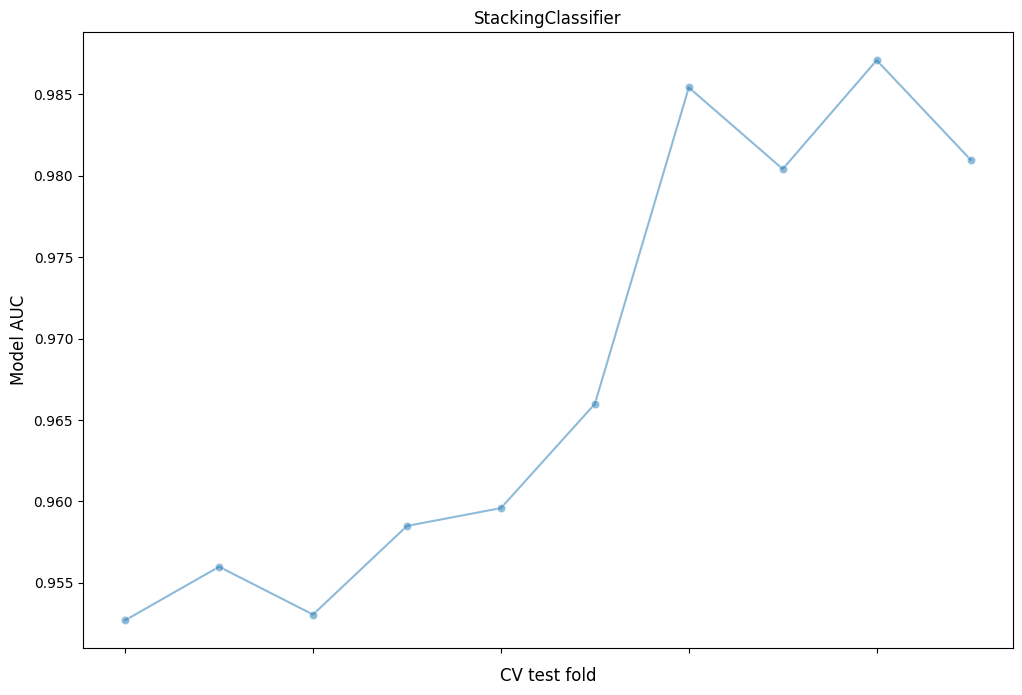

In [ ]:
#gerando gráfico
fig, ax = plt.subplots()
sns.lineplot(
        data=resul_stc,
        dashes=False,
        palette="Set1",
        marker="o",
        alpha=0.5,
        ax=ax,
    )
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model AUC", size=12)
ax.set_title("StackingClassifier", size=12)
ax.tick_params(bottom=True, labelbottom=False)
plt.show()

# Rodada de Refinamento dos hiperparâmetros

## KNN
No primeiro momento realizamos um teste com o número de vizinhos variando de 1 até 30. O melhor número de vizinhos foi baixo, testamos agora se um número maior de vizinhos pode melhorar o algoritmo, por isso testamos valores entre ímpares no intervalo de 1 e 100. Outro parâmetro que passamos a testar foi o algoritmo utilizado. Por padrão o KNeighborsClassifier escolhe o algoritmo ideal durante a execução baseado nos valores passados ao método fit. Aqui, testamos explicitamente os tipos de algoritmos: **Força bruta**, o algoritmo mais simples, que realiza todas as comparações entre todos os pares de instâncias; **KD-tree**, um algoritmo com estrutura baseada em árvore binária, que reduz o número de cálculos de distância que precisam ser realizados; **Ball tree**, um algoritmo com a mesma intuição básica do KD-tree, mas que supera suas ineficiências em altas dimensões. Também passamos a testar o parâmetro leaf size, que se aplica ao Ball tree e KD-tree, entretanto esperamos que esse parâmetro não afete a acurácia da predição e por isso testamos apenas 3 valores.

Os resultados dos testes mostraram que não houve melhorias em relação a primeira execução do KNN, com uma pequena alteração dos hiperparâmetros.

In [ ]:
knn = KNeighborsClassifier(n_jobs=-1,p=3)

param_grid = {
    'n_neighbors': list(range(1, 101,2)), 
    'metric': ["euclidean", "manhattan", 'minkowski'],
    'weights': ['uniform', 'distance'],
    "algorithm":['ball_tree', 'kd_tree', 'brute'],
    "leaf_size":[15,30,45]
}

result_knn = search_best_estimator(knn, param_grid, X_train, y_train, cv)

print('=========Grid Search Results for KNN==========')
print('Best Score: %s' % result_knn.best_score_)
print('Best Hyperparameters: %s' % result_knn.best_params_)

best_knn = result_knn.best_estimator_

create_fig(result_knn)

 =========Grid Search Results for KNN==========

Best Score: 0.957490779619051

Best Hyperparameters: {'algorithm': 'ball_tree', 'leaf_size': 15, 'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
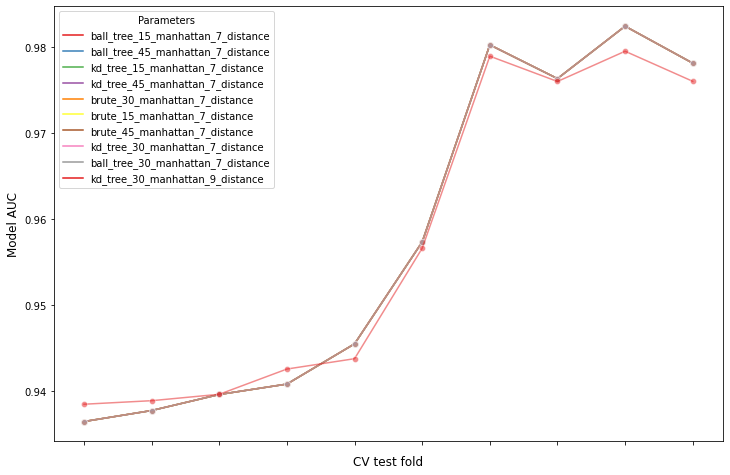

## Árvore de decisão

In [ ]:
decision_tree = DecisionTreeClassifier(random_state=seed_value)

param_space = {
    'criterion': ['gini', 'entropy', "log_loss"],
    'min_samples_split': [2,3,5,7],
    'max_depth': [3,5,6,7,9,11,13, None],
    'min_samples_leaf': [2,3,4,5,6],
    "ccp_alpha":[0.0, 0.01, 0.05, 0.1],
    "max_features": ["None","log2","sqrt"]
}

result_tree =  search_best_estimator(decision_tree, param_space, X_train, y_train, cv)

print('=========Grid Search Results for Decision Tree==========')
print('Best Score: %s' % result_tree.best_score_)
print('Best Hyperparameters: %s' % result_tree.best_params_)

best_tree = result_tree.best_estimator_
create_fig(result_tree)


Fitting 10 folds for each of 5760 candidates, totalling 57600 fits

=========Grid Search Results for Decision Tree==========

Best Score: 0.8958697193905438

Best Hyperparameters: {'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 7}
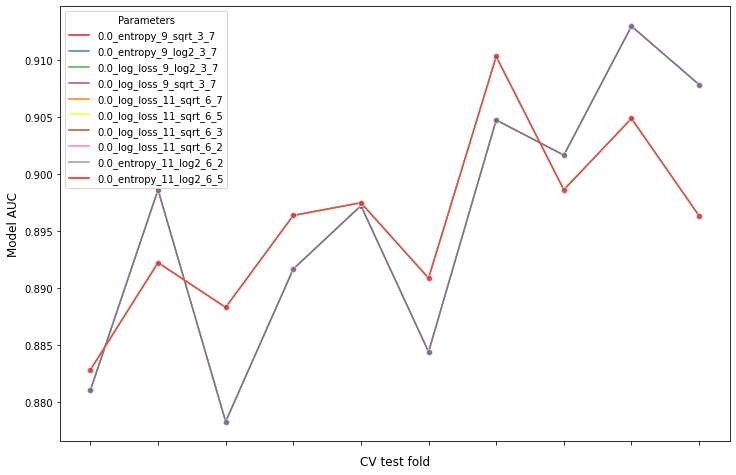



## Random Forest

In [ ]:
rfc = RandomForestClassifier(n_jobs=-1, random_state=seed_value)

param_space = {
    "n_estimators": [100, 150, 200],
    'criterion': ['gini', 'entropy', "log_loss"],
    'min_samples_split': [2,3,5,7],
    'max_depth': [17, 19, 21, 23, 25, 27, None],
    'min_samples_leaf': [2,3,4,5,6],
    "max_samples":[0.2, 0.5,1.0],
    "warm_start":[True, False]
}

result_rfc = search_best_estimator(rfc, param_space, X_train, y_train, cv)

print('=========Grid Search Results for Random Forrest==========')
print('Best Score: %s' % result_rfc.best_score_)
print('Best Hyperparameters: %s' % result_rfc.best_params_)

best_rfc = result_rfc.best_estimator_

create_fig(result_rfc)

Fitting 10 folds for each of 7560 candidates, totalling 75600 fits

## Redes Neurais

### 2ª etapa 
Na primeira fase de refinamento, alguns parâmetros foram marcadamente melhores que outros, entre eles a função de ativação "tanh" e o solver "adam". Alguns parâmetros praticamente não fizeram diferença. Entre eles a taxa de aprendizado e o valor alfa. A grande diferença no resultado final ficou por parte da arquitetura de camadas da rede. Por isso, neste refinamento utilizaremos a variação de parâmetro apenas na arquitetura de camadas, testando camadas não testadas anteriormente Deixando como invariáveis, os melhores parâmetros encontrados na primeira execução.

In [ ]:
params_grid = {'hidden_layer_sizes':[(10,10), (20,20), (20, 50), (30, 50), (5,5,5), (10, 20, 10), (30, 20, 50)]}

mlp = MLPClassifier(random_state=seed_value, activation = "tanh", solver="adam",alpha = 0.00001, learning_rate="invscaling")

result_mlp = search_best_estimator(mlp, params_grid, X_train, y_train, cv)

print('=========Grid Search Results for MLP==========')
print('Best Score: %s' % result_mlp.best_score_)
print('Best Hyperparameters: %s' % result_mlp.best_params_)

best_mlp = result_mlp.best_estimator_
create_fig(result_mlp)

Fitting 10 folds for each of 7 candidates, totalling 70 fits

=========Grid Search Results for MLP==========

Best Score: 0.9427538648578786

Best Hyperparameters: {'hidden_layer_sizes': (30, 50)}
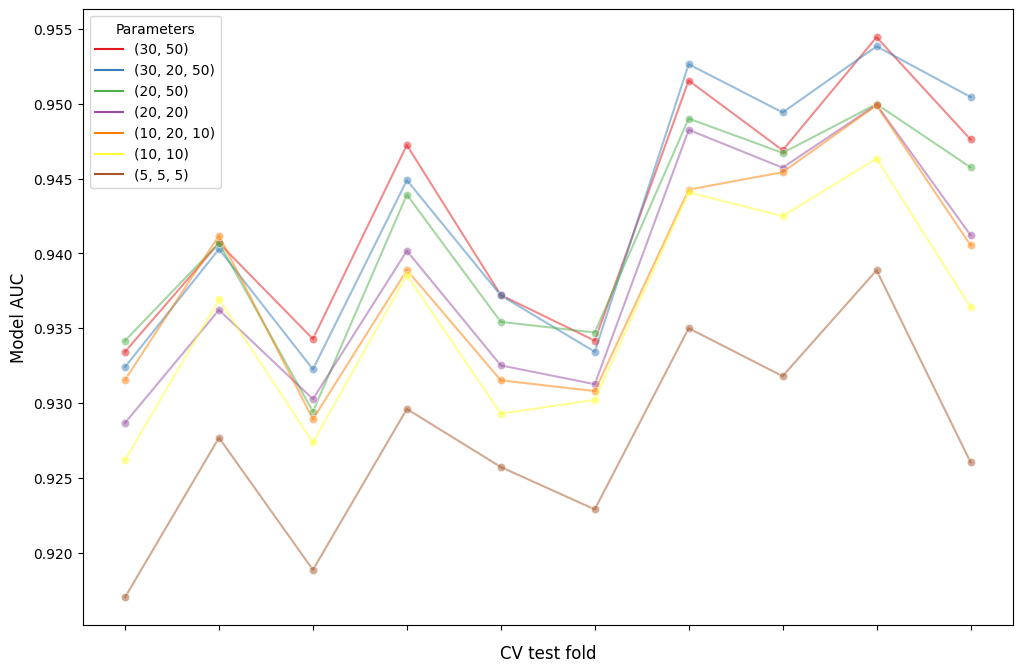

### 3ª etapa

In [ ]:
params_grid = {'hidden_layer_sizes':[ (30, 50),(50, 50), (50, 100), (100, 100), (30, 20, 50), (50,50,50)]}

mlp = MLPClassifier(random_state=seed_value, activation = "tanh", solver="adam",alpha = 0.00001, learning_rate="invscaling")

result_mlp = search_best_estimator(mlp, params_grid, X_train, y_train, cv)

print('=========Grid Search Results for MLP==========')
print('Best Score: %s' % result_mlp.best_score_)
print('Best Hyperparameters: %s' % result_mlp.best_params_)

best_mlp = result_mlp.best_estimator_
create_fig(result_mlp)

Fitting 10 folds for each of 6 candidates, totalling 60 fits

=========Grid Search Results for MLP==========

Best Score: 0.9478667580254841

Best Hyperparameters: {'hidden_layer_sizes': (50, 50, 50)}
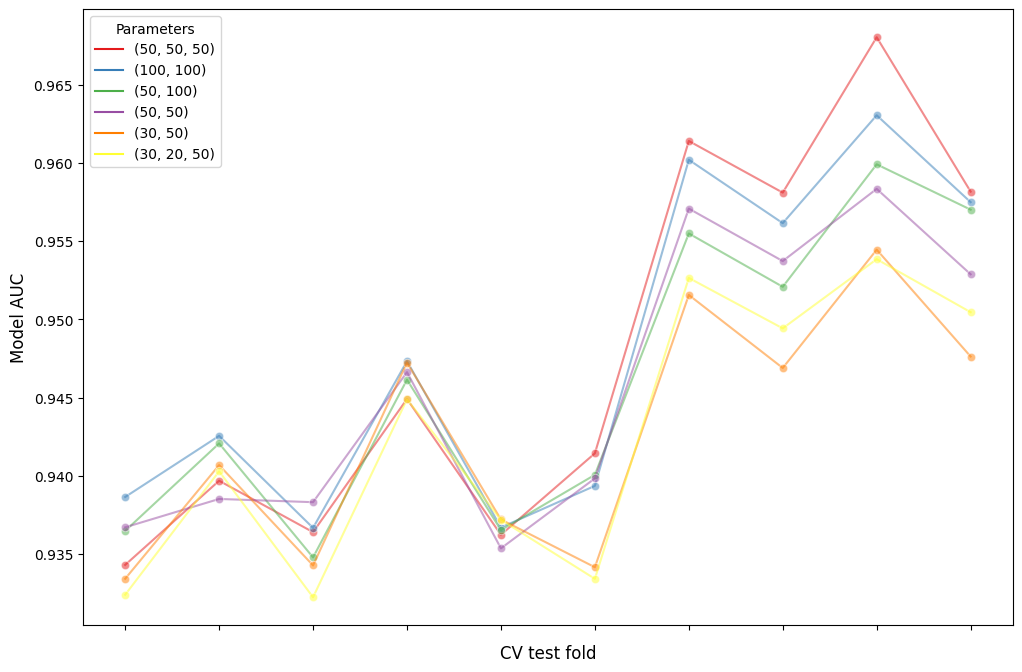

### 4ª etapa

In [ ]:
params_grid = {'hidden_layer_sizes':[(50,50,50), (80,80,80), (100, 100, 100), (50, 50, 50, 50)]}

mlp = MLPClassifier(random_state=seed_value, activation = "tanh", solver="adam",alpha = 0.00001, learning_rate="invscaling")

result_mlp = search_best_estimator(mlp, params_grid, X_train, y_train, cv)

print('=========Grid Search Results for MLP==========')
print('Best Score: %s' % result_mlp.best_score_)
print('Best Hyperparameters: %s' % result_mlp.best_params_)

best_mlp = result_mlp.best_estimator_
create_fig(result_mlp)

Fitting 10 folds for each of 4 candidates, totalling 40 fits

=========Grid Search Results for MLP==========

Best Score: 0.9560936249558223

Best Hyperparameters: {'hidden_layer_sizes': (100, 100, 100)}
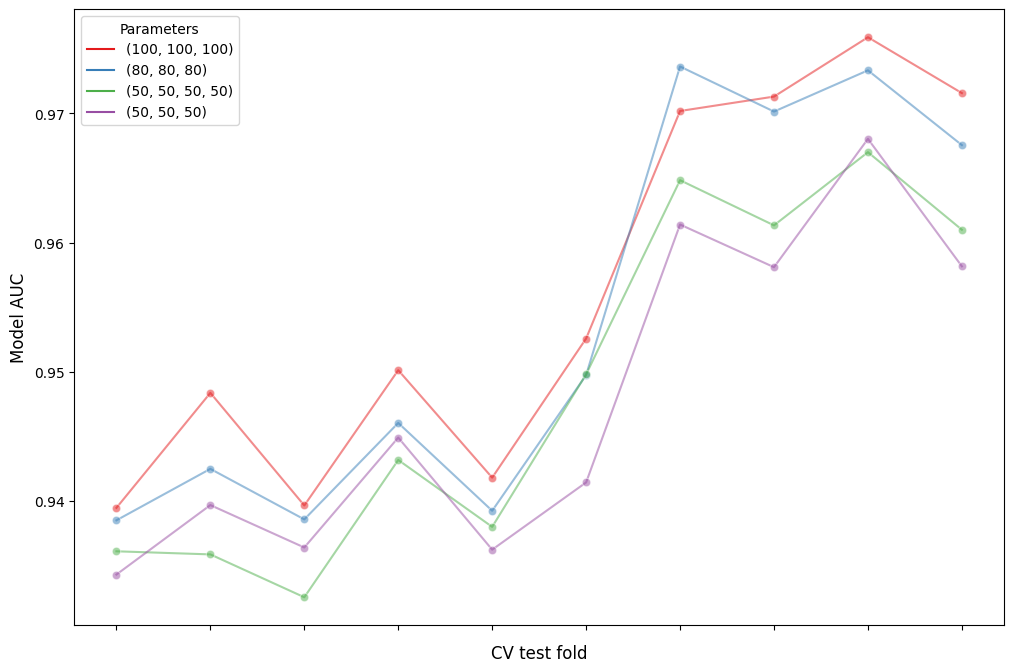

## Comitê de Redes
Anteriormente tentamos otimizar o comitê utilizando valores de até 150 instâncias da base. Isso, contudo , resultou em um péssimo score. Nesta execução fizemos tudo diferente, uma vez que até a própria configuração da melhor rede foi alterada. Decidimos variar, nesta etapa, apenas os estimadores de base, utilizando como input, 50% das instâncias da base de dados.

In [ ]:
params_grid = {'n_estimators': [10,25,50]}

bmlp = BaggingClassifier(base_estimator = best_mlp, n_jobs= -1, random_state=seed_value, max_samples=0.5)
result_bmlp = search_best_estimator(bmlp, params_grid, X_train, y_train, cv)

print('=========Grid Search Results for BMLP==========')
print('Best Score: %s' % result_bmlp.best_score_)
print('Best Hyperparameters: %s' % result_bmlp.best_params_)

best_bmlp = result_bmlp.best_estimator_
print(best_bmlp)
create_fig(result_bmlp)

In [ ]:
#criando manualmente os classificadores com base nas saídas anteriores (para não executar tudo novamente)
best_mlp = MLPClassifier(activation= 'tanh', alpha= 1e-05, hidden_layer_sizes= (10, 10), learning_rate='invscaling', solver= 'adam', random_state=seed_value)
best_knn = KNeighborsClassifier(metric= 'manhattan', n_neighbors= 6, weights= 'distance')
best_rfc = RandomForestClassifier(criterion= 'entropy', max_depth= 19, min_samples_leaf= 2, min_samples_split= 3, random_state=seed_value)
best_tree = DecisionTreeClassifier(criterion= 'entropy', max_depth= 9, min_samples_leaf= 3, min_samples_split= 2, random_state=seed_value)
best_bmlp = BaggingClassifier(base_estimator=best_mlp, max_features=7, max_samples=150, n_estimators=50, random_state=seed_value)
best_svc = SVC(C= 10, gamma= 1, kernel= 'rbf', random_state=seed_value)